# 04_THF_frictionvelocity_mooring

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../')
import plot_simply.geomap as geomap
import data_UniBremen.SIC as UNISIC

import geofunc.vectors as vectors
import geofunc.general as geo


In [2]:
def grab_atm(time_range, lat = 70.5 , lon = -140):
    
    # year1
    DS1 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.start.year}.nc')
    DS1.close()
    time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
    DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)

    # year2
    DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
    DS2.close()
    time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
    DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

    # combine
    ds4 = xr.concat([DS1, DS2], dim="time")
    
    return ds4
    

## Import data

In [10]:
# Save to file
df = pd.read_csv('./data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(3340.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [4]:
#===============================================================

# 2016-2017
time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
# time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 4, 30,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']


# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))



lat, lon = 70.5, -140 
ds4 = grab_atm(time_range, lat = lat, lon = lon)
ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


### Evaluate data gaps

In [5]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -3.3 [0.25] 
z = -5.3 [0.92] 
z = -7.3 [0.93] 
z = -9.3 [0.95] 
z = -11.3 [0.94] 
z = -13.3 [0.94] 
z = -15.3 [0.97] *
z = -17.3 [0.98] *
z = -19.3 [0.97] *
z = -21.3 [0.27] 
z = -23.3 [0.98] *
z = -25.3 [0.99] *
z = -29.3 [0.99] *
z = -31.3 [0.99] *
z = -33.3 [0.99] *
z = -35.3 [0.86] 

Ocean temperatures:
z = -16.0 [0.97] *
z = -22.0 [0.98] *
z = -28.0 [0.96] *
z = -39.0 [0.92] 

Sea ice velocity:
z = -39.0 [0.98] *


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34640/1511898339.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34640/1511898339.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34640/1511898339.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


<IPython.core.display.Javascript object>


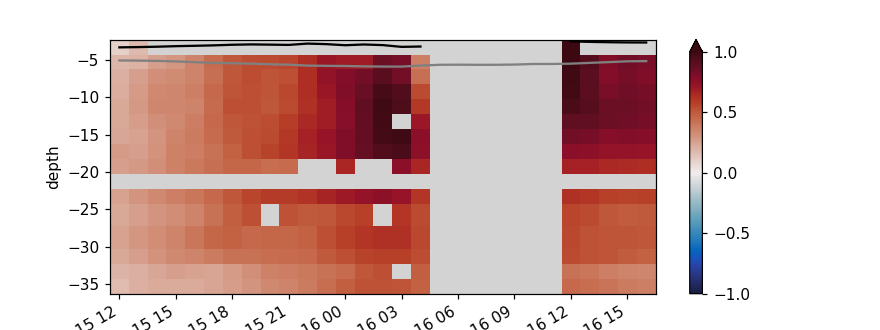

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


# event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))


along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


In [7]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

M1 = {}
M1['lon'] = np.array([ds3.attrs['lon']])
M1['lat'] = np.array([ds3.attrs['lat']])
M1['xx'], M1['yy'] = map_proj.transform_point(M1['lon'], M1['lat'], ccrs.PlateCarree())


print(M1)

{'lon': array([-139.2548]), 'lat': array([69.7706]), 'xx': 29683.48517136154, 'yy': -2282128.986714848}


<IPython.core.display.Javascript object>


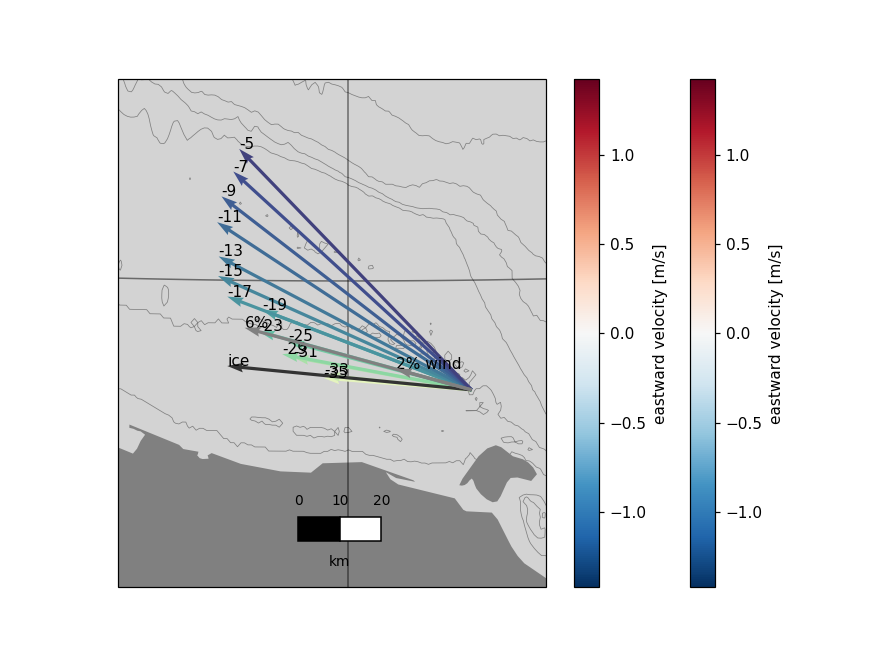

In [225]:

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_xlim(-180000,100000)
ax.set_ylim(-2330000,-2100000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(69,75,1), lons = np.arange(200,250,5) , color='k')

geomap.scalebar(ax, loc=(0.6, 0.05), stepsize=10, numsteps=2, unit='km', label=None, 
                colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                labelpad=0.015, ticklabelpad=0.01, zorder=100)

# ax.scatter(*tail, c='k')


label_side = 'left'

geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                        crop_lat=(69, 71), crop_lon=(-147, -135), clat=2, clon=5, 
                        contour_labels=False,
                        contour_levels=[-500,-300,-200,-100,  -40,-20],
                        contour_kwargs={'colors': 'gray', 'linewidths': 0.5, 'linestyles': 'solid', 'zorder': 1},
                        depth_shade=False)


# wind
U = 0.06 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.06 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = vectors.project_vectors(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '6%', ha=label_side, color='k',)

U = 0.02 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.02 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = vectors.project_vectors(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '2% wind', ha=label_side, color='k',)

# ice drift 
Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = vectors.project_vectors(map_proj, M1['lon'], M1['lat'], eastward = Ui, northward = Vi)
ax.quiver(*tail, *vec, color=[0.2,0.2,0.2], pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=3)
ax.text(*tip, 'ice', ha=label_side, color='k',)

# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        
        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')

        tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
        ax.quiver(*tail, *vec, color=color, pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=2)
        ax.text(*tip, f'{depth:.0f}', ha=label_side, color='k',)



<IPython.core.display.Javascript object>


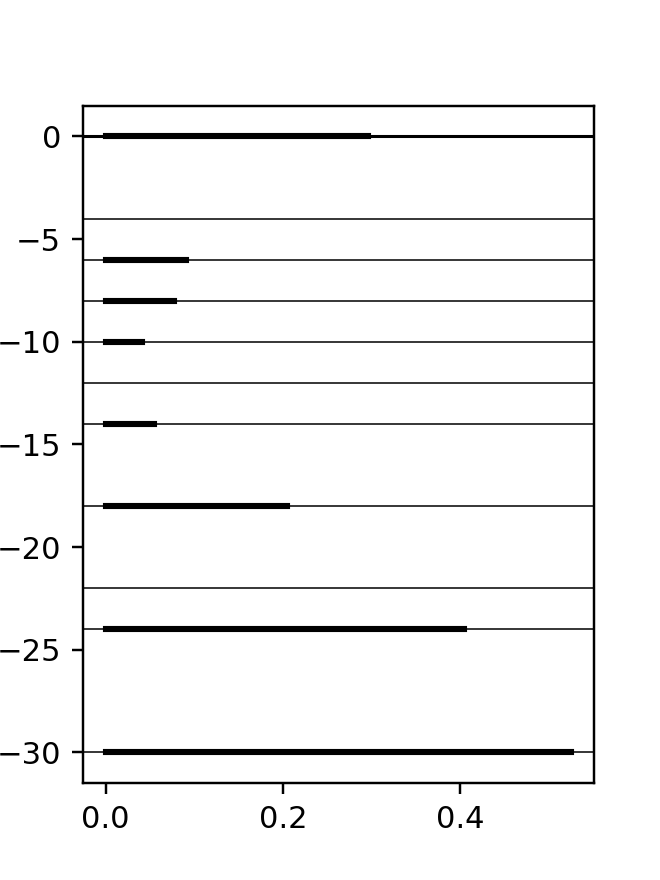

In [1481]:
# ice drift 
# Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

Ui = np.array([ds.u.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds.v.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')

fig, ax = plt.subplots(figsize=(3,4))
ax.axhline(0, lw=1, c='k', zorder=0)
# ax.set_xlim(-0.1,1)
# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    ax.axhline(depth, lw=0.5, c='k', zorder=0)
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        
        vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
        
        ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)

        
U = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
depth=0
ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)




<IPython.core.display.Javascript object>


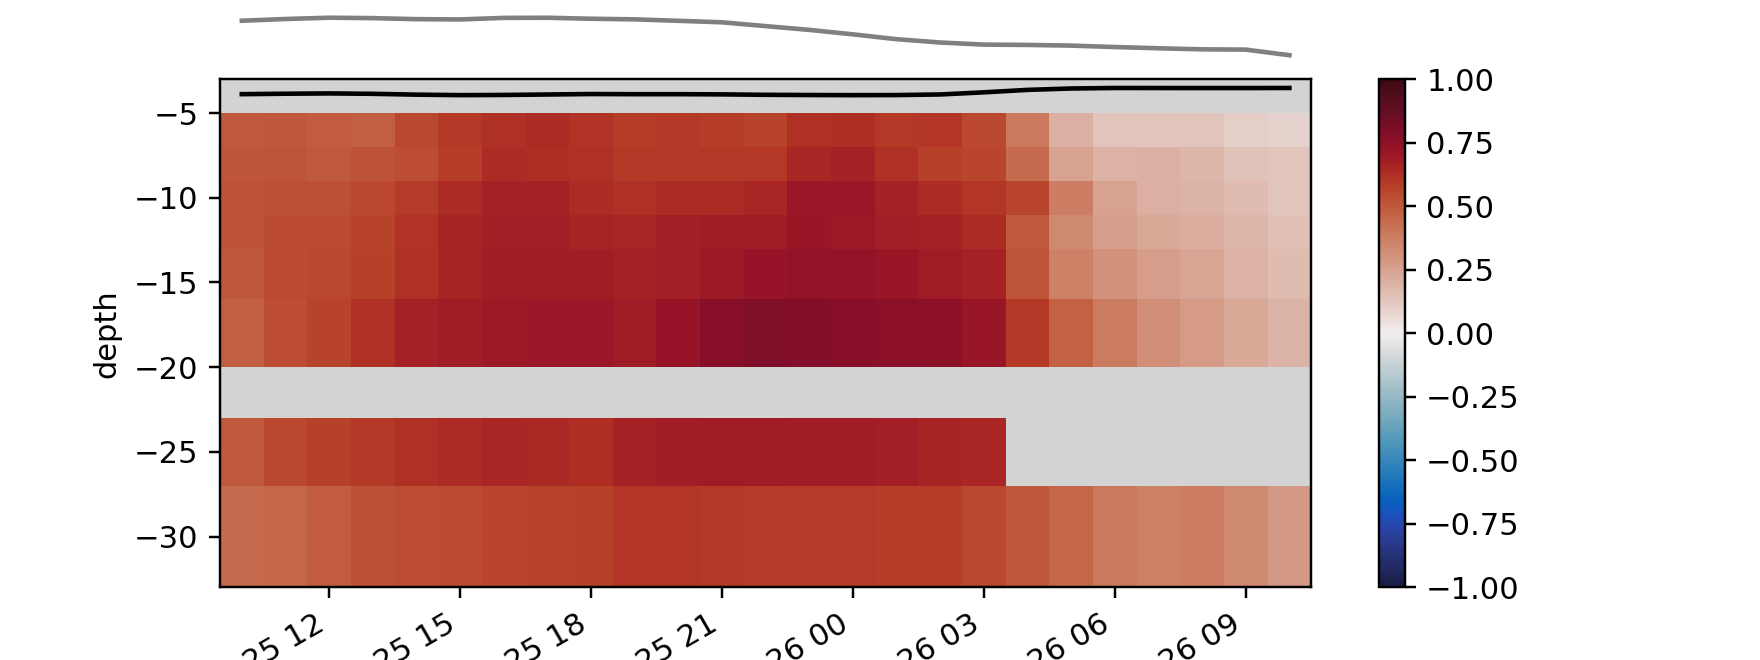

In [1680]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

# event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


# event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))

# event_time = slice(datetime(2019,1,28,6), datetime(2019,1,29, ))
# event_time = slice(datetime(2019,1,27), datetime(2019,1,31, ))
event_time = slice(datetime(2018,2,25,10), datetime(2018,2,26, 10))

along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<IPython.core.display.Javascript object>


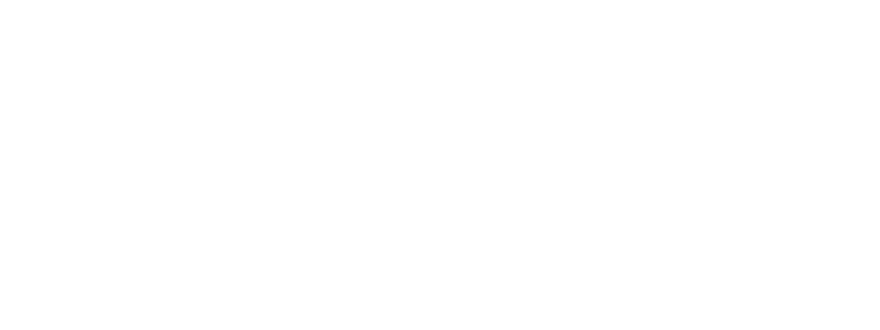

<IPython.core.display.Javascript object>


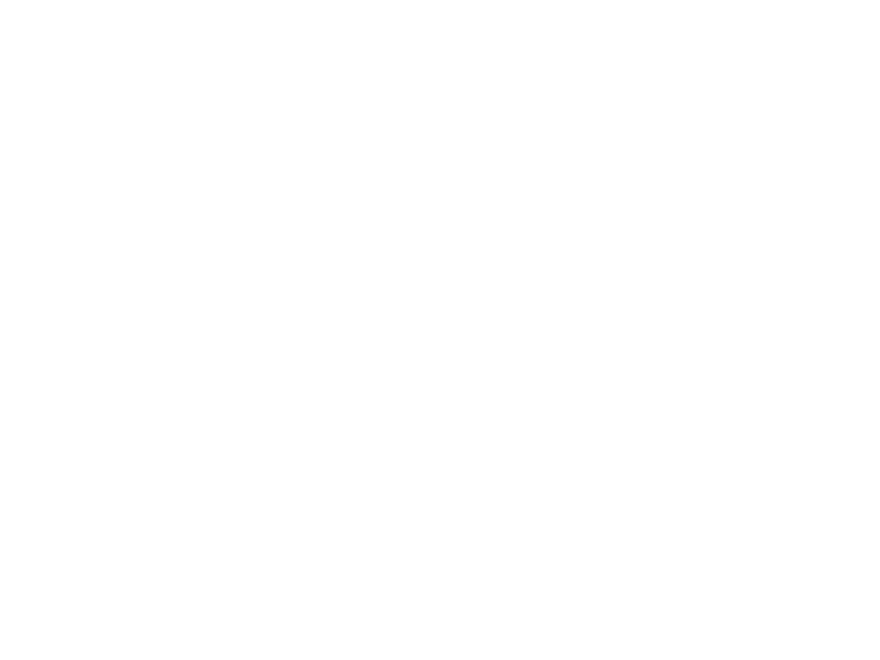

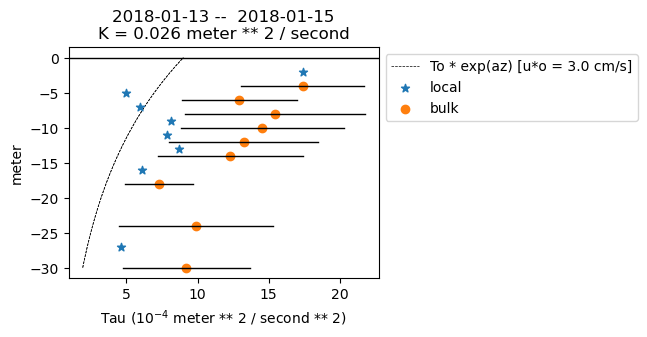

In [50]:
%matplotlib inline

def simple_exp_tau(z, K = 0.026 * units('m2/s'), lat = 70, To = 10*10**(-4) * units('m2/s2')):
    
    # coriolis frequency
    om = 7.2921 * 10 **(-5)
    f = 2 * om * np.sin(lat*np.pi/180) * units('s')**(-1)
    a = np.sqrt(0.5*f/K)
    T = To * np.exp(a * z)
    
    return T

    




scale = 10**(-4)
fig, ax = plt.subplots(figsize=(4,3))
ax.axhline(0, lw=1, c='k', zorder=0)

z = np.linspace(-30,0,100) * units('m')


K = 0.026 * units('m2/s')


Uos = np.array([0.03]) * units('m/s')
Tos = Uos**2

for To in Tos:
    T = simple_exp_tau(z, To = To, K = K)
    plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5)
    
uslabel = (Uos[0].to('cm/s')).magnitude
plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5, label=f'To * exp(az) [u*o = {uslabel:.1f} cm/s]')

Ui = ds3.u
Vi = ds3.v

urel = (ds.u - Ui) 
vrel = (ds.v - Vi)

dudz_x = (urel / ds.depth ) * (1/units('s'))
dudz_y = (vrel / ds.depth ) * (1/units('s'))
dudz = np.sqrt(dudz_x**2+dudz_y**2)
# zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) * units('m')


z = ds.depth.values * units('m')
event_shear = dudz.sel(time=event_time).mean(dim='time').values * (1/units('s'))
event_shear_std = dudz.sel(time=event_time).std(dim='time').values * (1/units('s'))



dudz_x = ds.u.diff('depth') / ds.depth.diff('depth')
dudz_y = ds.v.diff('depth') / ds.depth.diff('depth')
dudz = np.sqrt(dudz_x**2+dudz_y**2)

shear_local = dudz.sel(time=event_time).mean(dim='time').values

top_z = ds.depth[-1]
top_shear = np.sqrt((urel.sel(depth=top_z)/ (top_z))**2+(vrel.sel(depth=top_z)/ (top_z))**2)
shear_local = np.append(shear_local, top_shear.sel(time=event_time).mean(dim='time'))
shear_local = shear_local * (1/units('s'))

TL = (shear_local * K)
zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) 
zmid = np.append(zmid, top_z/2)
zmid = zmid * units('m')
plt.scatter(TL/scale, zmid, marker='*', label='local', zorder=2)

T2 = (event_shear * K)
T2min = ((event_shear - event_shear_std) * K)
T2max = ((event_shear + event_shear_std) * K)

plt.scatter(T2/scale, z, label='bulk', zorder=1)

for min_, max_, z_ in zip(T2min.magnitude, T2max.magnitude, z.magnitude):
    plt.plot([min_/scale, max_/scale], [z_,z_], c='k', lw=1)
    
    

# ax.set_xlim(-0.0001/scale,0.002/scale) 
plt.xlabel('Tau ($10^{-4}$'+f' {T2.units})')
plt.legend(bbox_to_anchor=(1,1))



ax.set_title(f'{event_time.start.date()} --  {event_time.stop.date()}\nK = {K}')

fig.savefig(f'./figures/stress/stress_profile_{event_time.start.date()}_{event_time.stop.date()}.png', dpi=300, bbox_inches = 'tight', pad_inches=0)

# Newton Iteration

https://personal.math.ubc.ca/~anstee/math104/newtonmethod.pdf 

In [51]:

import cmath

In [52]:
def create_V(depth, date):

    # ocean vector (in cm/s)
    uo = (ds.u.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vo = (ds.v.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Uo = complex(uo, vo)
    
    # ice vector (in cm/s)
    ui = (ds3.u.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vi = (ds3.v.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Ui = complex(ui, vi)
    
    # ice velocity with ocean removed
    V = Ui - Uo
    # Get polar coordinates
    # r, phi = cmath.polar(V)

    return Uo, Ui, V

In [62]:


def newton_iter(xn, V, k = 0.4, A = 2.3, B = 2.1, lat = 70, z0 = 5 * units('cm')):
    
    # coriolis frequency
    f = geo.coriolis(lat)
    
    # surface friction rossby number
    unm = cmath.polar(xn)[0] * units('cm/s')
    
    unR = xn.real
    alpha = 1/(f*z0)
    c = complex(A, B)
    
    Fn = V - (1/k) * (np.log(alpha*unm) - c) * xn
    dFdun = - (1/k) * ((unR/unm.magnitude**2)*xn + np.log(alpha*unm) - c)
    
    xnp1 = xn - Fn/dFdun
    
    return xnp1, Fn


## Rossby similarity version

In [266]:
starttime = datetime.now()

dates = pd.date_range(datetime(2016,12,1), datetime(2017,4,30,23), freq = '1H')
# dates = pd.date_range(datetime(2017,12,1), datetime(2018,4,30,23), freq = '1H')
# dates = pd.date_range(datetime(2018,12,1), datetime(2019,2,15,23), freq = '1H')

us0 = {}
z0_vals = [0.0001, 0.001, 0.05] # in units of m
# depths = [-30,-10,-6] # in units of m
depths = [-35.3, -29.3,-23.3,-15.3,-9.3,-5.3] # in units of m

for z0 in z0_vals:
    us0[z0] = {}
    for depth in depths:
        us0[z0][depth] = np.array([])
    

for dd, date in enumerate(dates):
    
    if dd%240 == 0:
        print(date.date(), f'[dt = {(datetime.now() - starttime).total_seconds():.0f} s]')
    
    for z0 in z0_vals:
    
        for depth in depths:
            
            all_us = np.array([])

            # relaive ice-ocean velocities
            Uo, Ui, V = create_V(depth, date)

            # initial guess
            x0 = 5 * cmath.exp(1j * np.pi/4)
            
            # newton iteration
            #-----------------
            guesses = [x0]
            tolerance = 0.001
            num_iter = 50

            for ii in range(num_iter):

                xn = guesses[-1]
                xnp1, Fn = newton_iter(xn, V, k = cst['kappa'], A = 2.3, B = 2, z0 = z0 * units('m'))
                guesses.append(xnp1)

                dx = xnp1 - xn
                if cmath.polar(dx)[0] < tolerance:
                    break

            if ii < num_iter-1:
                us0[z0][depth] = np.append(us0[z0][depth], guesses[-1])
            else:
                us0[z0][depth] = np.append(us0[z0][depth], np.nan)

                
# grab magnitudes
usm = {}
for z0 in z0_vals:
    usm[z0] = {}
    for depth in depths:
        usm[z0][depth] = np.array([])
        for us in us0[z0][depth]:
            usm[z0][depth] = np.append(usm[z0][depth], cmath.polar(us)[0])
            
print(f'>>>> runtime: {datetime.now() - starttime}')

2016-12-01 [dt = 0 s]


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/plain/quantity.py:1006: RuntimeWarning: invalid value encountered in scalar divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


2016-12-11 [dt = 67 s]
2016-12-21 [dt = 168 s]
2016-12-31 [dt = 238 s]
2017-01-10 [dt = 308 s]
2017-01-20 [dt = 378 s]
2017-01-30 [dt = 446 s]
2017-02-09 [dt = 514 s]
2017-02-19 [dt = 598 s]
2017-03-01 [dt = 672 s]
2017-03-11 [dt = 775 s]
2017-03-21 [dt = 893 s]
2017-03-31 [dt = 964 s]
2017-04-10 [dt = 1086 s]
2017-04-20 [dt = 1178 s]
2017-04-30 [dt = 1258 s]
>>>> runtime: 0:21:09.487633


<IPython.core.display.Javascript object>


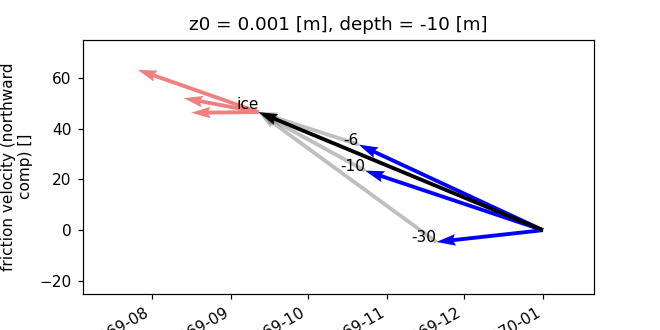

In [200]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(6,3))
size = 200
ax.set_xlim(-0.9*size,0.1*size)
ax.set_ylim(-size/8, 3*size/8)

ax.quiver(0,0,Ui.real, Ui.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='k', zorder=10)
ax.text(Ui.real, Ui.imag, 'ice', ha='right', va='bottom')

sc = 10
for depth in depths:
    
    # relaive ice-ocean velocities
    Uo, Ui, V = create_V(depth, date)
    ax.quiver(0,0,Uo.real, Uo.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='b' )
    ax.quiver(Uo.real, Uo.imag, V.real, V.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', 
              color='k', alpha=0.25, ls='dashed')
    ax.text(Uo.real, Uo.imag, depth, ha='right')
    
    ax.quiver(Ui.real, Ui.imag, sc*us0[z0][depth][-1].real, sc*us0[z0][depth][-1].imag, 
              angles='xy', scale_units='xy', scale=1, pivot='tail', color='lightcoral' )
    



## Save to NC

In [267]:
# real component
usm_r = np.array([])
for depth in depths:
    for z0 in z0_vals:
        usm_r = np.append(usm_r, us0[z0][depth].real)
usm_r = np.reshape(usm_r, (len(depths), len(z0_vals), len(dates)))

# imag component
usm_i = np.array([])
for depth in depths:
    for z0 in z0_vals:
        usm_i = np.append(usm_i, us0[z0][depth].imag)
usm_i = np.reshape(usm_i, (len(depths), len(z0_vals), len(dates)))


# create NC
#---------------
data_vars = {}
data_vars["us0x"] = (("depth", "z0", "time"), usm_r, {'long_name': "friction velocity (eastward comp)", 'units':"cm/s"})
data_vars["us0y"] = (("depth", "z0", "time"), usm_i, {'long_name': "friction velocity (northward comp)", 'units': "cm/s"})
data_vars["us0"] = (("depth", "z0", "time"), np.sqrt(usm_r**2+usm_i**2), {'long_name': "friction velocity", 'units': "cm/s"})

data_coords = {}
data_coords["time"] = (("time"), dates, {'long_name': "date/time (UTC)"})
data_coords["z0"] = (("z0"), z0_vals, {'long_name': "roughness parameter", 'units':"m"})
data_coords["depth"] = (("depth"), depths, {'long_name': "reference depth", 'units':'m'})


dss = xr.Dataset(data_vars, coords=data_coords)   

# save to file
# mainpath = './data/friction_velocity/'
# filename = f"us_rosssim_{dates[-1].year}_v0.nc"
# dss.to_netcdf(mainpath+filename)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_51633/1645024793.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathrm{u_{*0}}$\n$\mathrm{(cm\;{s}^{-1})}$', rotation=0, labelpad=25)


<IPython.core.display.Javascript object>


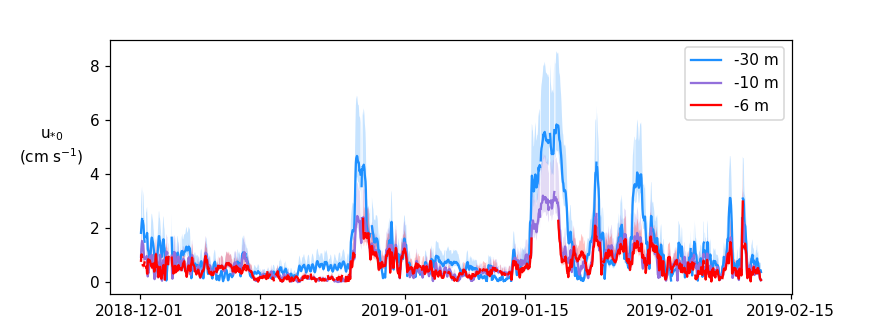

Text(0, 0.5, '$\\mathrm{u_{*0}}$\n$\\mathrm{(cm\\;{s}^{-1})}$')

In [234]:
fig, ax = plt.subplots(figsize=(8,3))


colors = ['dodgerblue', 'mediumpurple', 'red']

for depth, color in zip([-30,-10,-6], colors):
        
    plt.plot(dates, dss.us0.sel(z0 = 0.001, depth=depth),  color=color, lw=1.5, label=f'{depth} m')
    plt.fill_between(dates, dss.us0.sel(z0 = 0.0001, depth=depth), dss.us0.sel(z0 = 0.05, depth=depth), color=color, alpha=0.25, lw=0)

    
plt.legend()
plt.ylabel('$\mathrm{u_{*0}}$\n$\mathrm{(cm\;{s}^{-1})}$', rotation=0, labelpad=25)

## Log layer version

In [268]:
us0 = {}

# z0_vals = [0.0001, 0.001, 0.05] # in units of m
# depths = [-30,-10,-6] # in units of m
# depths = [-39.3,-23.3,-15.3,-9.3,-5.3] # in units of m

for z0 in z0_vals:
    us0[z0] = {}
    for depth in depths:
        us0[z0][depth] = np.array([])
      
    
for dd, date in enumerate(dates):
    
    if dd%240 == 0:
        print(date.date(), f'[dt = {(datetime.now() - starttime).total_seconds():.0f} s]')
    
    for z0 in z0_vals:
    
        for depth in depths:

            # relaive ice-ocean velocities
            Uo, Ui, V = create_V(depth, date)
            
            us = cst['kappa'] * (1 / np.log(- depth / z0)) * V
            
            us0[z0][depth] = np.append(us0[z0][depth], us)

2016-12-01 [dt = 1270 s]
2016-12-11 [dt = 1291 s]
2016-12-21 [dt = 1312 s]
2016-12-31 [dt = 1333 s]
2017-01-10 [dt = 1351 s]
2017-01-20 [dt = 1369 s]
2017-01-30 [dt = 1386 s]
2017-02-09 [dt = 1404 s]
2017-02-19 [dt = 1422 s]
2017-03-01 [dt = 1442 s]
2017-03-11 [dt = 1464 s]
2017-03-21 [dt = 1485 s]
2017-03-31 [dt = 1503 s]
2017-04-10 [dt = 1522 s]
2017-04-20 [dt = 1541 s]
2017-04-30 [dt = 1560 s]


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_51633/3278399642.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathrm{u_{*0}}$\n$\mathrm{(cm\;{s}^{-1})}$', rotation=0, labelpad=25)


<IPython.core.display.Javascript object>


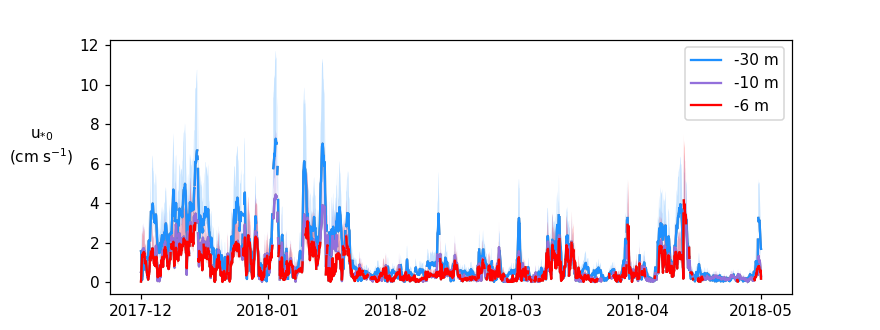

Text(0, 0.5, '$\\mathrm{u_{*0}}$\n$\\mathrm{(cm\\;{s}^{-1})}$')

In [261]:

fig, ax = plt.subplots(figsize=(8,3))


colors = ['dodgerblue', 'mediumpurple', 'red']

for depth, color in zip([-30,-10,-6], colors):
        
    plt.plot(dates, dss.us0.sel(z0 = 0.001, depth=depth),  color='gray', lw=1.5)
    plt.fill_between(dates, dss.us0.sel(z0 = 0.0001, depth=depth), dss.us0.sel(z0 = 0.05, depth=depth), color=color, alpha=0.25, lw=0)

    plt.plot(dates, np.sqrt(us0[0.001][depth].real**2 + us0[0.001][depth].imag**2).magnitude,  color=color, lw=1.5, label=f'{depth} m')
    
    
plt.legend()
plt.ylabel('$\mathrm{u_{*0}}$\n$\mathrm{(cm\;{s}^{-1})}$', rotation=0, labelpad=25)

In [269]:
# real component
usm_r = np.array([])
for depth in depths:
    for z0 in z0_vals:
        usm_r = np.append(usm_r, us0[z0][depth].real)
usm_r = np.reshape(usm_r, (len(depths), len(z0_vals), len(dates)))

# imag component
usm_i = np.array([])
for depth in depths:
    for z0 in z0_vals:
        usm_i = np.append(usm_i, us0[z0][depth].imag)
usm_i = np.reshape(usm_i, (len(depths), len(z0_vals), len(dates)))


# create NC
#---------------
data_vars = {}
data_vars["us0x"] = (("depth", "z0", "time"), usm_r, {'long_name': "friction velocity (eastward comp)", 'units':"cm/s"})
data_vars["us0y"] = (("depth", "z0", "time"), usm_i, {'long_name': "friction velocity (northward comp)", 'units': "cm/s"})
data_vars["us0"] = (("depth", "z0", "time"), np.sqrt(usm_r**2+usm_i**2), {'long_name': "friction velocity", 'units': "cm/s"})

data_coords = {}
data_coords["time"] = (("time"), dates, {'long_name': "date/time (UTC)"})
data_coords["z0"] = (("z0"), z0_vals, {'long_name': "roughness parameter", 'units':"m"})
data_coords["depth"] = (("depth"), depths, {'long_name': "reference depth", 'units':'m'})


dss = xr.Dataset(data_vars, coords=data_coords)   

# save to file
# mainpath = './data/friction_velocity/'
# filename = f"us_loglayer_{dates[-1].year}_v0.nc"
# dss.to_netcdf(mainpath+filename)

In [55]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
# time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 13,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']

# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)
ds2['dT'] = ds2.Ct - ds2.Tf


# friction velocity
ds5 = xr.open_dataset(f'./data/friction_velocity/us_loglayer_{time_range.stop.year}_v0.nc')
ds5 = ds5.sel(time=time_range)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)



lat, lon = 70.5, -140 
ds4 = grab_atm(time_range, lat = lat, lon = lon)
ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))

<IPython.core.display.Javascript object>


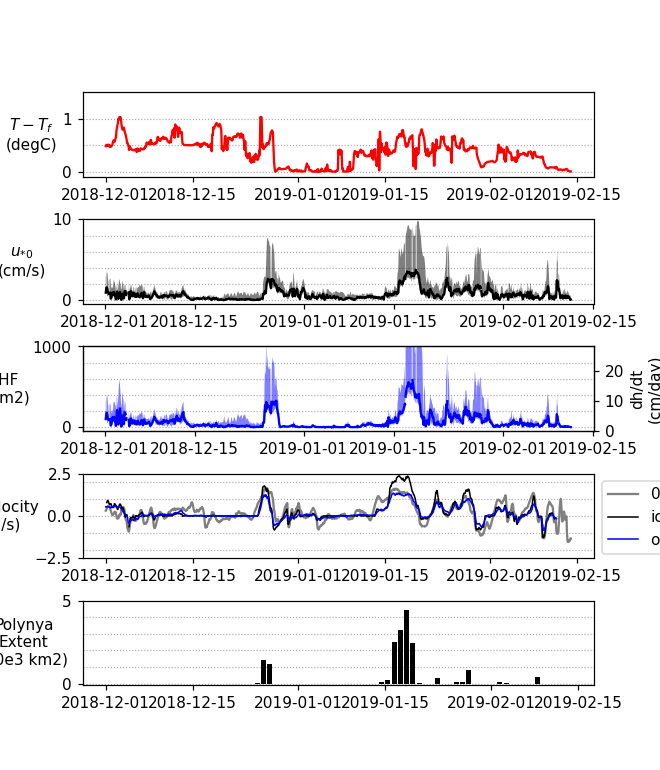

In [536]:
%matplotlib notebook

fig, axs = plt.subplots(5,1,figsize = (6,7))
plt.subplots_adjust(hspace=0.5)


ax = axs[0]
ax.set_ylabel('$T-T_{f}$\n(degC)', rotation=0, labelpad = 20, va='center')
ax.set_ylim(-0.1,1.5)
for val in [0,0.5,1,1.5]:
    ax.axhline(val, c='darkgray', lw=0.75, ls='dotted', zorder=-1)
    
ax = axs[1]
ax.set_ylabel('$u_{*0}$\n(cm/s)', rotation=0, labelpad = 20, va='center')
ax.set_ylim(-0.5,10)
for val in [0,2,4,6,8]:
    ax.axhline(val, c='darkgray', lw=0.75, ls='dotted', zorder=-1)

ax = axs[2]
ax.set_ylabel('OHF\n(W/m2)', rotation=0, labelpad = 20, va='center')
ax.set_ylim(-50,1000)
for val in [0,200,400,600,800,1000]:
    ax.axhline(val, c='darkgray', lw=0.75, ls='dotted', zorder=-1)
    
# label as dh/dt 
ax2 = axs[2].twinx()
# Latent heat of fusion of ice
Li = 3.340e5 * units('J/kg')
# Density of ice & 917 kg m^{-3}
pi = 917 * units('kg/m3')
dhdt = (1000*units('W/m2') / (Li*pi)).to('cm/day')
ax2.set_ylim(0, dhdt.magnitude)
ax2.set_yticks([0,10,20])
ax2.set_ylabel('dh/dt\n(cm/day)')


    
ax = axs[3]
ax.set_ylabel('SE Velocity\n(cm/s)', rotation=0, labelpad = 25, va='center')
ax.set_ylim(-2.5,2.5)
for val in [-2,-1,0,1,2]:
    ax.axhline(val, c='darkgray', lw=0.75, ls='dotted', zorder=-1)
# ax3 = axs[3].twinx()
# ax3.set_ylim(0, dhdt.magnitude)
# ax3.set_yticks([-20,20])
# ax3.set_ylabel('dh/dt\n(cm/day)')


ax = axs[4]
ax.set_ylabel('Polynya\nExtent\n(10e3 km2)', rotation=0, labelpad = 25, va='center')
ax.set_ylim(-0.1,5)
for val in [0,1,2,3,4]:
    ax.axhline(val, c='darkgray', lw=0.75, ls='dotted', zorder=-1)
    
dt = ds2.dT.sel(depth=-16).values * units('delta_degC')
us = ds5.us0.sel(depth=-10, z0 = 0.001).values * units('cm/s')

# find min/max vals
us_min = np.copy(us.magnitude)
us_max = np.copy(us.magnitude)
for depth in ds5.depth.values:
    for z0 in ds5.z0.values:
        ust = ds5.us0.sel(depth=depth, z0 = z0).values
        us_min[ust<us_min] = ust[ust<us_min]
        us_max[ust>us_max] = ust[ust>us_max]
us_min = us_min * units('cm/s')  
us_max = us_max * units('cm/s')  

OHF = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us.to('m/s') * dt).to('W/m2')
OHF_min = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us_min.to('m/s') * dt).to('W/m2')
OHF_max = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us_max.to('m/s') * dt).to('W/m2')

ax = axs[0]
ax.plot(ds2.time, dt, c='r')

ax = axs[1]
ax.plot(ds2.time, us, c='k')
ax.fill_between(ds2.time, us_min, us_max, alpha=0.5, lw=0, color='k')

ax = axs[2]
ax.plot(ds2.time, OHF, c='blue')
ax.fill_between(ds2.time, OHF_min, OHF_max, alpha=0.5, lw=0, color='blue')

ax = axs[3]
ax.plot(ds4.time, ds4.se/10, c='gray', label='0.1 * wind')
ax.plot(ds3.time, ds3.se, c='k', lw=1, label='ice')
ax.plot(ds.time, ds.se.mean('depth'), c='blue',lw=1,  label='ocean')
ax.legend(bbox_to_anchor=(1,1))

ax = axs[4]
ax.bar(DS.time, DS.extent/1000, align='edge', color='k')
ax.bar(DS.time[DS.miss_flag.values], 
       np.zeros(len(DS.time[DS.miss_flag.values]))+ax.get_ylim()[-1], align='edge', color='gray')


fig.savefig(f'./figures/heatflux/heat_flux_estimates_{time_range.stop.year}.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [385]:
dt.shape

(3624,)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_51633/309227500.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('OHF (W\m2)')
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


<IPython.core.display.Javascript object>


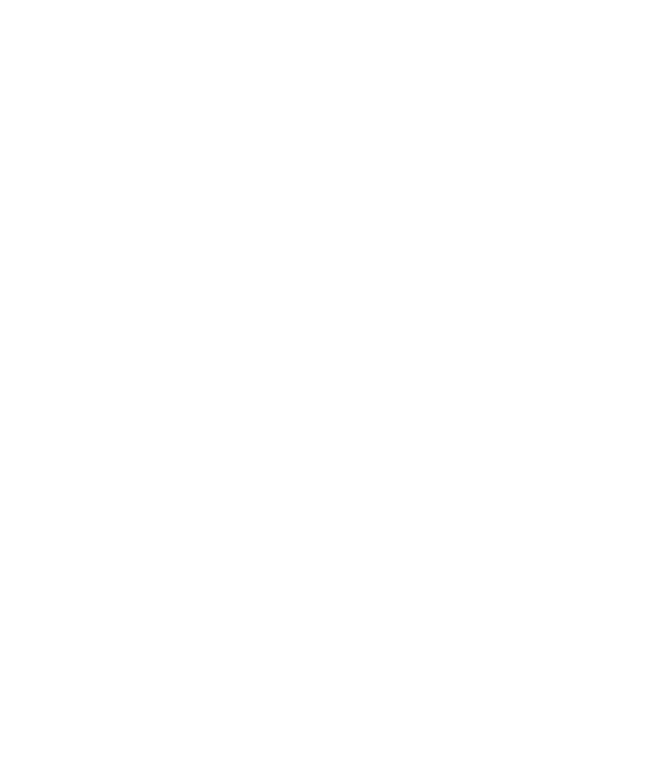

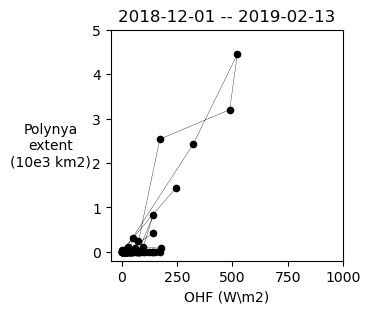

In [537]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (3,3))

ax.set_title(f'{time_range.start.date()} -- {time_range.stop.date()}')

OHF_daily = []
for ii in np.arange(24,len(OHF)+1,24):
    OHF_daily.append(np.nanmean(OHF[ii-24:ii]))
ax.plot(OHF[::24], DS.extent/1000, c='k', lw=0.25)
ax.scatter(OHF[::24], DS.extent/1000, c='k', s=20)

ax.set_ylabel('Polynya\nextent\n(10e3 km2)', labelpad=30, rotation=0, va='center')
ax.set_xlabel('OHF (W\m2)')
ax.set_ylim(-0.2,5)
ax.set_xlim(-50,1000)

fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
import timeseries.adjust as tseries

NameError: name 'tseries' is not defined

<IPython.core.display.Javascript object>


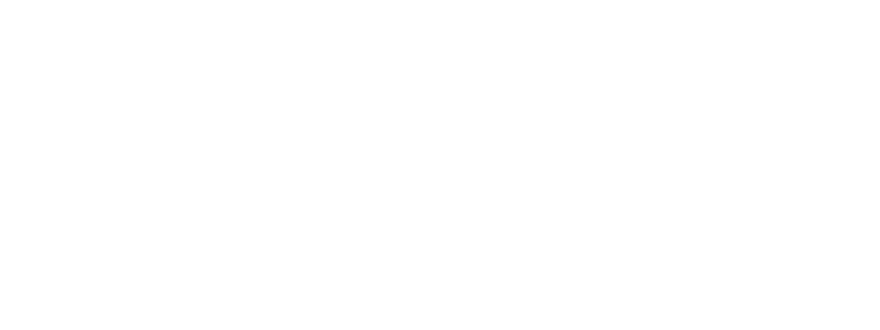

<IPython.core.display.Javascript object>


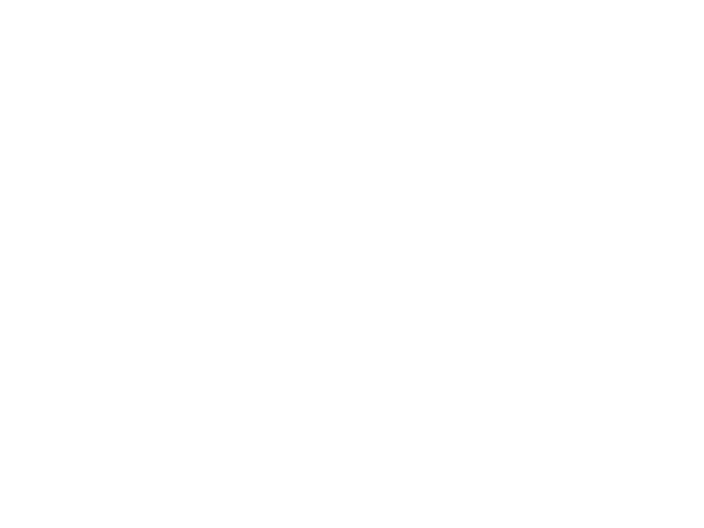

<IPython.core.display.Javascript object>


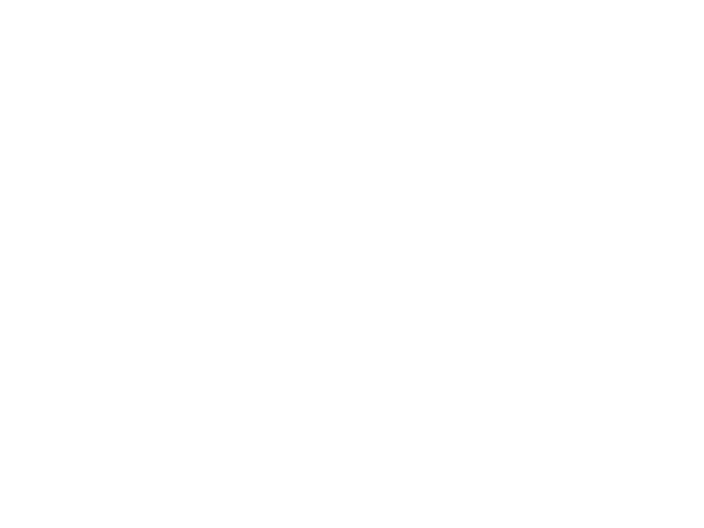

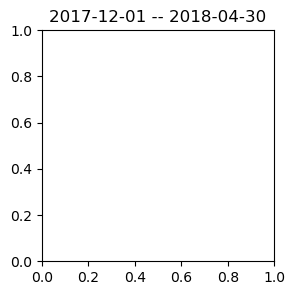

In [48]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (3,3))

ax.set_title(f'{time_range.start.date()} -- {time_range.stop.date()}')

# ax.scatter(ds4.se.values, OHF, c='k', s=1)

ax.scatter(tseries.running_mean(ds4.se.values, length=3*24, center=False, address_nans=True), 
           tseries.running_mean(OHF, length=3*24, center=False, address_nans=True),
           c='k', s=2)

# ax.set_ylabel('Polynya\nextent\n(10e3 km2)', labelpad=20, rotation=0, va='center')
ax.set_xlabel('3-day mean\nSE wind (m/s)')
ax.set_ylabel('3-day mean\nOHF\n(W/m2)', labelpad=40, rotation=0, va='center')
ax.set_ylim(-10,600)
ax.set_xlim(-15,15)

fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

## Save heat fluxes

In [70]:

# find desired dates 
dates1 = pd.date_range(time_range.start, time_range.stop, freq='1H')
dates2 = pd.date_range(time_range.start, datetime(time_range.stop.year, 4, 30, 23), freq='1H')

In [69]:
#
# dates = pd.date_range(time_range.start, time_range.stop, freq='1H')

# ocean heat flux
OHF = np.array([])

for depth in ds5.depth:
    for z0 in ds5.z0:
        
        us = ds5.us0.sel(z0=z0, depth=depth).values * units(ds5.us0.units)
        dt = ds2.dT.sel(depth=-16).values * units('delta_degC')
        thf = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us.to('m/s') * dt).to('W/m2')
        
        # extend if data does not 
        if len(dates2) > len(dates1):
            thf = np.append(thf, np.full((len(dates2) - len(thf)), np.nan) * units('W/m2'))
        
        OHF = np.append(OHF, thf)
        
OHF = np.reshape(OHF, (len(ds5.depth.values), len(ds5.z0.values), len(dates2)))

In [72]:
# create NC
#---------------
data_vars = {}
data_vars["OHF"] = (("depth", "z0", "time"), OHF, {'long_name': "turbulent ocean-to-ice heat flux", 'units':"W/m2"})

data_coords = {}
data_coords["time"] = (("time"), dates2, {'long_name': "date/time (UTC)"})
data_coords["z0"] = (("z0"), ds5.z0.values, {'long_name': "roughness parameter", 'units':"m"})
data_coords["depth"] = (("depth"), ds5.depth.values, {'long_name': "reference depth", 'units':'m'})


dss = xr.Dataset(data_vars, coords=data_coords, attrs={'description': 'OHF from rossby similarity friction velocities and T-Tf a 16m depth'})   

# save to file
mainpath = './data/heat_flux/'
filename = f"ohf_{time_range.stop.year}_v0.nc"
dss.to_netcdf(mainpath+filename)